In [ ]:
# Standard Library
import os

# Scientific Stack
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
%matplotlib inline

# Audio Processing
import librosa
import librosa.display

# Utils
import joblib

# Machine Learning (sklearn)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    precision_score,
    recall_score,
    f1_score,
)

# Deep Learning (TensorFlow / Keras)
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout,
    TimeDistributed, BatchNormalization, LSTM
)
from tensorflow.keras.callbacks import EarlyStopping


In [ ]:
test_label = pd.read_csv("../data/processed/test_label.csv")
test_label["attack_id"]

0          -
1          -
2          -
3          -
4          -
        ... 
22066    A19
22067    A19
22068    A19
22069    A19
22070    A19
Name: attack_id, Length: 22071, dtype: object

In [ ]:
numeric_test = pd.read_csv("../data/processed/numeric_test_data.csv")
numeric_test.head()

,chroma_1,chroma_2,chroma_3,chroma_4,chroma_5,chroma_6,chroma_7,chroma_8,chroma_9,chroma_10,...,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,mfcc_20,label
0,0.294816,0.503692,0.480659,0.486471,0.567629,0.621212,0.744608,0.801118,0.494999,0.379941,...,0.536610,0.466130,0.308717,0.618259,0.538676,0.477636,0.470927,0.631759,0.248168,0
1,0.617019,0.545311,0.379189,0.405296,0.391390,0.399742,0.351910,0.392575,0.473532,0.456885,...,0.367245,0.449308,0.227763,0.564726,0.483087,0.510242,0.302176,0.796255,0.188663,0
2,0.444568,0.674772,0.507009,0.446029,0.439376,0.560138,0.652452,0.585583,0.385803,0.424773,...,0.556336,0.561057,0.474945,0.656124,0.536349,0.575920,0.416949,0.713852,0.269293,0
3,0.353409,0.372058,0.435908,0.637940,0.718656,0.648835,0.532033,0.450481,0.409119,0.315358,...,0.476340,0.601510,0.360674,0.577678,0.319412,0.604456,0.290465,0.629287,0.321853,0
4,0.445617,0.598166,0.593869,0.598029,0.676531,0.721887,0.655631,0.793946,0.785415,0.789627,...,0.406823,0.598791,0.392434,0.699011,0.386863,0.545826,0.465624,0.840376,0.363315,0


In [12]:
X_test_numeric = numeric_test.iloc[:, :-1]
y_test_numeric = numeric_test.iloc[:, -1]

### RANDOM FOREST

In [ ]:
feature_rf = [
    'chroma_1', 'chroma_2', 'chroma_3', 'chroma_4', 'chroma_8', 'chroma_9',
    'chroma_11', 'chroma_12', 'spectral_bandwidth_mean',
    'spectral_rolloff_mean', 'mfcc_1', 'mfcc_3', 'mfcc_4', 'mfcc_5',
    'mfcc_6', 'mfcc_7', 'mfcc_8', 'mfcc_9', 'mfcc_10', 'mfcc_11', 'mfcc_12',
    'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 'mfcc_17', 'mfcc_18',
    'mfcc_19', 'mfcc_20'
]

X_test_rf = X_test_numeric[feature_rf]
rf_model  = joblib.load("../load/best_model_rf.pkl")

✅ Test Accuracy (RF): 80.77%


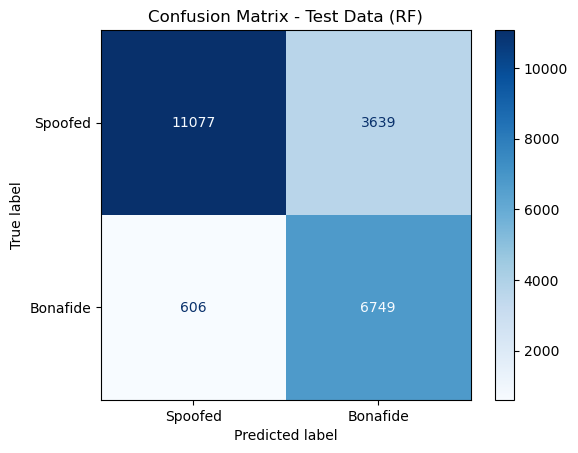

In [14]:
y_pred_test_rf = rf_model.predict(X_test_rf)
test_acc_rf = accuracy_score(y_test_numeric, y_pred_test_rf)
print(f"✅ Test Accuracy (RF): {test_acc_rf * 100:.2f}%")

cf_test_rf = confusion_matrix(y_test_numeric, y_pred_test_rf, labels=[1, 0])
ConfusionMatrixDisplay(cf_test_rf, display_labels=["Spoofed", "Bonafide"]).plot(cmap="Blues")
plt.title("Confusion Matrix - Test Data (RF)")
plt.show()

In [15]:
X_test_result_rf = X_test_rf.copy()
X_test_result_rf["y_actual"] = y_test_numeric.values
X_test_result_rf["y_pred"] = y_pred_test_rf
X_test_result_rf["attack_id"] = test_label["attack_id"]

# Tambahkan kolom 'is_correct' untuk menandai apakah prediksi benar
X_test_result_rf["is_correct"] = X_test_result_rf["y_actual"] == X_test_result_rf["y_pred"]

# Hitung jumlah benar dan salah per attack_id
grouped_rf = X_test_result_rf.groupby(["attack_id", "is_correct"]).size().unstack(fill_value=0)

# Rename kolom agar jelas
grouped_rf = grouped_rf.rename(columns={True: "benar", False: "salah"})

# Tambahkan kolom total
grouped_rf["total"] = grouped_rf["benar"] + grouped_rf["salah"]

# Urutkan berdasarkan jumlah salah
grouped_rf = grouped_rf.sort_values(by="salah", ascending=False)

# Hitung persentase kesalahan
grouped_rf["RF"] = grouped_rf["salah"] / grouped_rf["total"]

# Tampilkan hasil
print("📊 Rekap klasifikasi per attack_id untuk Random Forest:")
grouped_rf

📊 Rekap klasifikasi per attack_id untuk Random Forest:


is_correct,salah,benar,total,RF
attack_id,,,,
A18,1076,56,1132,0.950530
A17,938,194,1132,0.828622
-,606,6749,7355,0.082393
A12,559,573,1132,0.493816
A15,312,820,1132,0.275618
A13,204,928,1132,0.180212
A10,198,934,1132,0.174912
A14,190,942,1132,0.167845
A11,153,979,1132,0.135159


### SVM

In [ ]:
feature_svm = ['chroma_1', 'chroma_4', 'chroma_7', 'chroma_8', 'chroma_11', 'rms_mean',
       'spectral_centroid_mean', 'spectral_bandwidth_mean',
       'spectral_rolloff_mean', 'zcr_mean', 'mfcc_1', 'mfcc_2', 'mfcc_3',
       'mfcc_4', 'mfcc_5', 'mfcc_6', 'mfcc_7', 'mfcc_9', 'mfcc_10', 'mfcc_14',
       'mfcc_17', 'mfcc_18', 'mfcc_19', 'mfcc_20']

X_test_svm = X_test_numeric[feature_svm]
svm_model = joblib.load("../load/svm_best_model.pkl")

✅ Test Accuracy (SVM): 67.66%


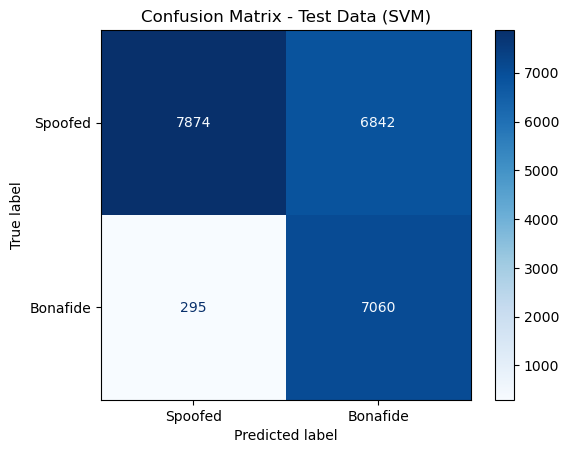

In [17]:
# Prediksi menggunakan model SVM
y_pred_test_svm = svm_model.predict(X_test_svm)

# Hitung akurasi
test_acc_svm = accuracy_score(y_test_numeric, y_pred_test_svm)
print(f"✅ Test Accuracy (SVM): {test_acc_svm * 100:.2f}%")

# Buat dan tampilkan Confusion Matrix
cf_test_svm = confusion_matrix(y_test_numeric, y_pred_test_svm, labels=[1, 0])
ConfusionMatrixDisplay(cf_test_svm, display_labels=["Spoofed", "Bonafide"]).plot(cmap="Blues")
plt.title("Confusion Matrix - Test Data (SVM)")
plt.show()

In [18]:
X_test_result_svm = X_test_svm.copy()
X_test_result_svm["y_actual"] = y_test_numeric.values
X_test_result_svm["y_pred"] = y_pred_test_svm
X_test_result_svm["attack_id"] = test_label["attack_id"]

# Tambahkan kolom 'is_correct' untuk menandai apakah prediksi benar
X_test_result_svm["is_correct"] = X_test_result_svm["y_actual"] == X_test_result_svm["y_pred"]

# Hitung jumlah benar dan salah per attack_id
grouped_svm = X_test_result_svm.groupby(["attack_id", "is_correct"]).size().unstack(fill_value=0)

# Rename kolom agar jelas
grouped_svm = grouped_svm.rename(columns={True: "benar", False: "salah"})

# Tambahkan kolom total
grouped_svm["total"] = grouped_svm["benar"] + grouped_svm["salah"]

# Urutkan berdasarkan jumlah salah
grouped_svm = grouped_svm.sort_values(by="salah", ascending=False)

# Hitung persentase kesalahan
grouped_svm["SVM"] = grouped_svm["salah"] / grouped_svm["total"]

# Tampilkan hasil
print("📊 Rekap klasifikasi per attack_id untuk SVM:")
grouped_svm

📊 Rekap klasifikasi per attack_id untuk SVM:


is_correct,salah,benar,total,SVM
attack_id,,,,
A18,1088,44,1132,0.961131
A17,1002,130,1132,0.885159
A12,913,219,1132,0.806537
A15,892,240,1132,0.787986
A13,861,271,1132,0.760601
A10,829,303,1132,0.732332
A14,646,486,1132,0.570671
A11,600,532,1132,0.530035
-,295,7060,7355,0.040109


### CNN

In [ ]:
data_test_cnn = np.load("../data/processed/cnn_test_data.npz")
X_test_cnn = data_test_cnn["data"]
y_test_cnn = data_test_cnn["label"]

In [ ]:
model_cnn = load_model("../load/model_cnn_fix.h5")


690/690 ━━━━━━━━━━━━━━━━━━━━ 16s 22ms/step
✅ Test Accuracy (CNN): 91.43%


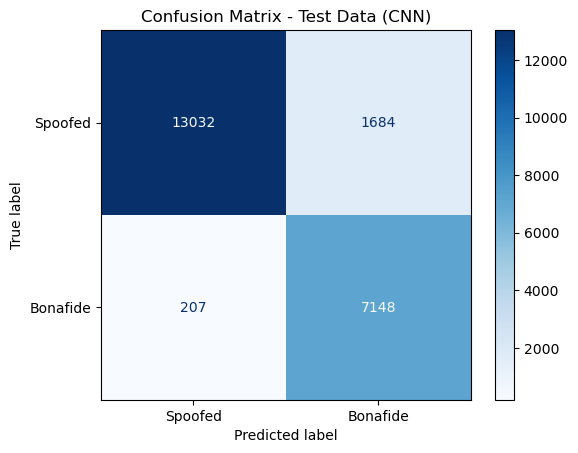

In [5]:
# ===== Evaluasi pada Data Testing =====
y_pred_test_cnn = model_cnn.predict(X_test_cnn)
y_pred_test_cnn_labels = (y_pred_test_cnn > 0.5).astype(int).flatten()
y_test_labels = y_test_cnn  # diasumsikan sudah dalam format label biner (0 atau 1)

# Akurasi
test_acc_cnn = accuracy_score(y_test_labels, y_pred_test_cnn_labels)
print(f"✅ Test Accuracy (CNN): {test_acc_cnn * 100:.2f}%")

# Confusion matrix
cf_test_cnn = confusion_matrix(y_test_labels, y_pred_test_cnn_labels, labels=[1, 0])
ConfusionMatrixDisplay(cf_test_cnn, display_labels=["Spoofed", "Bonafide"]).plot(cmap="Blues")
plt.title("Confusion Matrix - Test Data (CNN)")
plt.show()


In [6]:
test_cnn = pd.DataFrame()
# Pastikan DataFrame sudah berisi data prediksi dan label aktual
test_cnn["attack_id"] = test_label["attack_id"]
test_cnn["y_pred"] = y_pred_test_cnn_labels
test_cnn["y_actual"] = y_test_labels

# Tambahkan kolom 'is_correct' untuk menandai apakah prediksi benar
test_cnn["is_correct"] = test_cnn["y_actual"] == test_cnn["y_pred"]

# Hitung jumlah benar dan salah per attack_id
grouped_cnn = test_cnn.groupby(["attack_id", "is_correct"]).size().unstack(fill_value=0)

# Rename kolom agar jelas
grouped_cnn = grouped_cnn.rename(columns={True: "benar", False: "salah"})

# Tambahkan kolom total
grouped_cnn["total"] = grouped_cnn["benar"] + grouped_cnn["salah"]

# Urutkan berdasarkan jumlah salah
grouped_cnn = grouped_cnn.sort_values(by="salah", ascending=False)

# Hitung persentase kesalahan
grouped_cnn["CNN"] = grouped_cnn["salah"] / grouped_cnn["total"]

# Tampilkan hasil
print("📊 Rekap klasifikasi per attack_id untuk CNN:")
grouped_cnn

📊 Rekap klasifikasi per attack_id untuk CNN:


is_correct,salah,benar,total,CNN
attack_id,,,,
A17,644,488,1132,0.568905
A18,553,579,1132,0.488516
A19,318,814,1132,0.280919
-,207,7148,7355,0.028144
A08,104,1028,1132,0.091873
A07,18,1114,1132,0.015901
A10,18,1114,1132,0.015901
A11,13,1119,1132,0.011484
A16,8,1124,1132,0.007067


### CNN-LSTM

In [ ]:
data_test_cnn_lstm = np.load("../data/processed/cnn_lstm_test_data.npz")
X_test_cnn_lstm = data_test_cnn_lstm["data"]
y_test_cnn_lstm = data_test_cnn_lstm["label"]

In [ ]:
model_cnn_lstm = load_model("../load/model_cnn_lstm_fix.h5")  # atau direktori jika pakai SavedModel

690/690 [==============================] - 29s 38ms/step
✅ Test Accuracy (CNN-LSTM): 89.76%


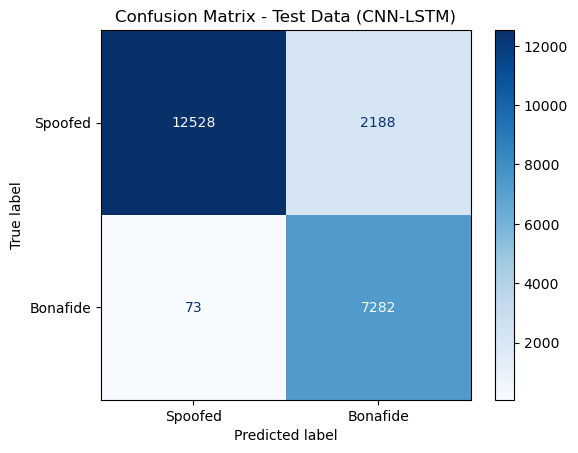

In [7]:
# ===== Evaluasi pada Data Testing =====
y_pred_test_cnn_lstm = model_cnn_lstm.predict(X_test_cnn_lstm)
y_pred_test_cnn_lstm_labels = (y_pred_test_cnn_lstm > 0.5).astype(int).flatten()
y_test_labels = y_test_cnn_lstm  # diasumsikan sudah dalam format label biner (0 atau 1)

# Akurasi
test_acc_cnn_lstm = accuracy_score(y_test_labels, y_pred_test_cnn_lstm_labels)
print(f"✅ Test Accuracy (CNN-LSTM): {test_acc_cnn_lstm * 100:.2f}%")

# Confusion matrix
cf_test_cnn_lstm = confusion_matrix(y_test_labels, y_pred_test_cnn_lstm_labels, labels=[1, 0])
ConfusionMatrixDisplay(cf_test_cnn_lstm, display_labels=["Spoofed", "Bonafide"]).plot(cmap="Blues")
plt.title("Confusion Matrix - Test Data (CNN-LSTM)")
plt.show()

In [39]:
test_cnn_lstm = pd.DataFrame()
# Pastikan DataFrame sudah berisi data prediksi dan label aktual
test_cnn_lstm["attack_id"] = test_label["attack_id"]
test_cnn_lstm["y_pred"] = y_pred_test_cnn_lstm_labels
test_cnn_lstm["y_actual"] = y_test_labels

# Tambahkan kolom 'is_correct' untuk menandai apakah prediksi benar
test_cnn_lstm["is_correct"] = test_cnn_lstm["y_actual"] == test_cnn_lstm["y_pred"]

# Hitung jumlah benar dan salah per attack_id
grouped_cnn_lstm = test_cnn_lstm.groupby(["attack_id", "is_correct"]).size().unstack(fill_value=0)

# Rename kolom agar jelas
grouped_cnn_lstm = grouped_cnn_lstm.rename(columns={True: "benar", False: "salah"})

# Tambahkan kolom total
grouped_cnn_lstm["total"] = grouped_cnn_lstm["benar"] + grouped_cnn_lstm["salah"]

# Urutkan berdasarkan jumlah salah
grouped_cnn_lstm = grouped_cnn_lstm.sort_values(by="salah", ascending=False)

# Hitung persentase kesalahan
grouped_cnn_lstm["CNN-LSTM"] = grouped_cnn_lstm["salah"] / grouped_cnn_lstm["total"]

# Tampilkan hasil
print("📊 Rekap klasifikasi per attack_id untuk CNN-LSTM:")
grouped_cnn_lstm

📊 Rekap klasifikasi per attack_id untuk CNN-LSTM:


is_correct,salah,benar,total,CNN-LSTM
attack_id,,,,
A17,1107,25,1132,0.977915
A18,758,374,1132,0.669611
A12,106,1026,1132,0.093640
A13,76,1056,1132,0.067138
-,73,7282,7355,0.009925
A15,46,1086,1132,0.040636
A08,28,1104,1132,0.024735
A10,27,1105,1132,0.023852
A19,24,1108,1132,0.021201


In [ ]:
grouped_rf_fix = grouped_rf.reset_index().sort_values(by="attack_id")
grouped_rf_fix = grouped_rf_fix[["attack_id", "RF"]]
grouped_rf_fix.to_clipboard(index=False)

In [ ]:
grouped_svm_fix = grouped_svm.reset_index().sort_values(by="attack_id")
grouped_svm_fix = grouped_svm_fix[["attack_id", "SVM"]]
grouped_svm_fix.to_clipboard(index=False)

In [ ]:
grouped_cnn_fix = grouped_cnn.reset_index().sort_values(by="attack_id")
grouped_cnn_fix = grouped_cnn_fix[["attack_id", "CNN"]]
grouped_cnn_fix.to_clipboard(index=False)

In [ ]:
grouped_cnn_lstm_fix = grouped_cnn_lstm.reset_index().sort_values(by="attack_id")
grouped_cnn_lstm_fix = grouped_cnn_lstm_fix[["attack_id", "CNN-LSTM"]]
grouped_cnn_lstm_fix.to_clipboard(index=False)

In [ ]:
# Gabungkan grouped_rf_fix dengan grouped_svm_fix
merged_df = pd.merge(grouped_rf_fix, grouped_svm_fix, on="attack_id", how="left")

# Gabungkan hasil dengan grouped_cnn_fix
merged_df = pd.merge(merged_df, grouped_cnn_fix, on="attack_id", how="left")

# Gabungkan hasil akhir dengan grouped_cnn_lstm_fix
final_results = pd.merge(merged_df, grouped_cnn_lstm_fix, on="attack_id", how="left")

final_results.to_csv("../data/output/persentase_error_test.csv")

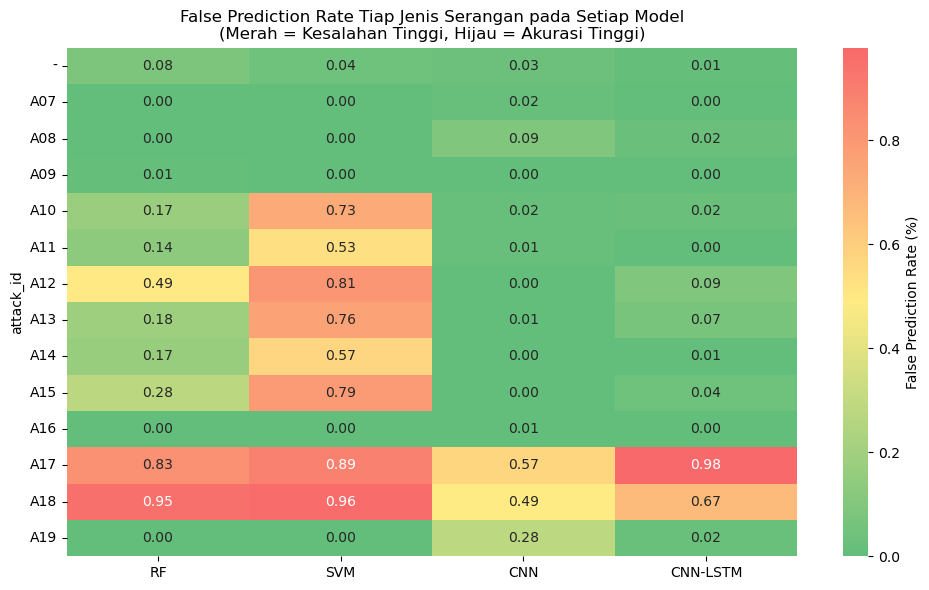

In [ ]:
# Data False Prediction Rate
false_rate = pd.read_csv("../data/output/persentase_error_test.csv")
false_rate.set_index("attack_id", inplace=True)

# Definisikan colormap hijau → kuning → merah
green_yellow_red = LinearSegmentedColormap.from_list(
    "GreenYellowRed", ["#63be7b", "#ffeb84", "#f8696b"]
)

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(
    false_rate,
    annot=True,
    fmt=".2f",
    cmap=green_yellow_red,
    cbar_kws={'label': 'False Prediction Rate (%)'}
)
plt.title(
    "False Prediction Rate Tiap Jenis Serangan pada Setiap Model\n"
    "(Merah = Kesalahan Tinggi, Hijau = Akurasi Tinggi)"
)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


### eksplorasi numerik

In [ ]:
test_label = pd.read_csv("../data/processed/test_label.csv")
test_label["attack_id"]

0          -
1          -
2          -
3          -
4          -
        ... 
22066    A19
22067    A19
22068    A19
22069    A19
22070    A19
Name: attack_id, Length: 22071, dtype: object

In [ ]:
data = pd.read_csv("../data/processed/numeric_test_data.csv")
data

,chroma_1,chroma_2,chroma_3,chroma_4,chroma_5,chroma_6,chroma_7,chroma_8,chroma_9,chroma_10,...,mfcc_12,mfcc_13,mfcc_14,mfcc_15,mfcc_16,mfcc_17,mfcc_18,mfcc_19,mfcc_20,label
0,0.294816,0.503692,0.480659,0.486471,0.567629,0.621212,0.744608,0.801118,0.494999,0.379941,...,0.536610,0.466130,0.308717,0.618259,0.538676,0.477636,0.470927,0.631759,0.248168,0
1,0.617019,0.545311,0.379189,0.405296,0.391390,0.399742,0.351910,0.392575,0.473532,0.456885,...,0.367245,0.449308,0.227763,0.564726,0.483087,0.510242,0.302176,0.796255,0.188663,0
2,0.444568,0.674772,0.507009,0.446029,0.439376,0.560138,0.652452,0.585583,0.385803,0.424773,...,0.556336,0.561057,0.474945,0.656124,0.536349,0.575920,0.416949,0.713852,0.269293,0
3,0.353409,0.372058,0.435908,0.637940,0.718656,0.648835,0.532033,0.450481,0.409119,0.315358,...,0.476340,0.601510,0.360674,0.577678,0.319412,0.604456,0.290465,0.629287,0.321853,0
4,0.445617,0.598166,0.593869,0.598029,0.676531,0.721887,0.655631,0.793946,0.785415,0.789627,...,0.406823,0.598791,0.392434,0.699011,0.386863,0.545826,0.465624,0.840376,0.363315,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22066,0.575486,0.709273,0.695486,0.766051,0.830473,0.770694,0.705974,0.714555,0.684441,0.788425,...,0.709133,0.406163,0.723416,0.506961,0.707798,0.349331,0.621979,0.452747,0.586745,1
22067,0.459799,0.512797,0.548949,0.736511,0.785032,0.800819,0.750141,0.770717,0.643879,0.786986,...,0.600375,0.501241,0.644758,0.595426,0.634791,0.321747,0.534121,0.648680,0.561448,1
22068,0.469171,0.616217,0.688349,0.746042,0.756301,0.782818,0.739287,0.872185,0.823696,0.700914,...,0.714227,0.577419,0.745214,0.623125,0.626379,0.328685,0.465577,0.516776,0.502891,1
22069,0.655198,0.756755,0.656292,0.753486,0.820120,0.871602,0.755098,0.775556,0.656615,0.692045,...,0.672704,0.405115,0.669679,0.633360,0.812845,0.356809,0.703286,0.524107,0.500577,1


In [14]:
data_test = pd.concat([data, test_label], axis=1)
data_test

,chroma_1,chroma_2,chroma_3,chroma_4,chroma_5,chroma_6,chroma_7,chroma_8,chroma_9,chroma_10,...,mfcc_16,mfcc_17,mfcc_18,mfcc_19,mfcc_20,label,Unnamed: 0,class_name,speaker_id,attack_id
0,0.294816,0.503692,0.480659,0.486471,0.567629,0.621212,0.744608,0.801118,0.494999,0.379941,...,0.538676,0.477636,0.470927,0.631759,0.248168,0,15382,bonafide,LA_0063,-
1,0.617019,0.545311,0.379189,0.405296,0.391390,0.399742,0.351910,0.392575,0.473532,0.456885,...,0.483087,0.510242,0.302176,0.796255,0.188663,0,15383,bonafide,LA_0034,-
2,0.444568,0.674772,0.507009,0.446029,0.439376,0.560138,0.652452,0.585583,0.385803,0.424773,...,0.536349,0.575920,0.416949,0.713852,0.269293,0,15384,bonafide,LA_0041,-
3,0.353409,0.372058,0.435908,0.637940,0.718656,0.648835,0.532033,0.450481,0.409119,0.315358,...,0.319412,0.604456,0.290465,0.629287,0.321853,0,15385,bonafide,LA_0031,-
4,0.445617,0.598166,0.593869,0.598029,0.676531,0.721887,0.655631,0.793946,0.785415,0.789627,...,0.386863,0.545826,0.465624,0.840376,0.363315,0,15386,bonafide,LA_0032,-
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22066,0.575486,0.709273,0.695486,0.766051,0.830473,0.770694,0.705974,0.714555,0.684441,0.788425,...,0.707798,0.349331,0.621979,0.452747,0.586745,1,37448,spoof,LA_0013,A19
22067,0.459799,0.512797,0.548949,0.736511,0.785032,0.800819,0.750141,0.770717,0.643879,0.786986,...,0.634791,0.321747,0.534121,0.648680,0.561448,1,37449,spoof,LA_0013,A19
22068,0.469171,0.616217,0.688349,0.746042,0.756301,0.782818,0.739287,0.872185,0.823696,0.700914,...,0.626379,0.328685,0.465577,0.516776,0.502891,1,37450,spoof,LA_0007,A19
22069,0.655198,0.756755,0.656292,0.753486,0.820120,0.871602,0.755098,0.775556,0.656615,0.692045,...,0.812845,0.356809,0.703286,0.524107,0.500577,1,37451,spoof,LA_0015,A19


In [15]:
data_fitur = data_test[data_test["attack_id"].isin(["-", "A08", "A17", "A18","A07"])].loc[:,["mfcc_19", "mfcc_6", "mfcc_3", "label", "attack_id"]]
data_fitur.sort_index()

,mfcc_19,mfcc_6,mfcc_3,label,attack_id
0,0.631759,0.267131,0.651186,0,-
1,0.796255,0.248210,0.594216,0,-
2,0.713852,0.224328,0.876674,0,-
3,0.629287,0.228845,0.811533,0,-
4,0.840376,0.308060,0.637093,0,-
...,...,...,...,...,...
20934,0.468979,0.164920,0.234618,1,A07
20935,0.414243,0.390391,0.556163,1,A07
20936,0.654777,0.431309,0.336221,1,A07
20937,0.342625,0.304502,0.622993,1,A07


In [16]:
data_fitur.loc[data_fitur["attack_id"] == "-", "attack_id"] = "Bonafide"

In [17]:
data_fitur["attack_id"].unique()

array(['Bonafide', 'A18', 'A08', 'A17', 'A07'], dtype=object)

C:\Users\USER\AppData\Local\Temp\ipykernel_24940\3129242968.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\USER\AppData\Local\Temp\ipykernel_24940\3129242968.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\USER\AppData\Local\Temp\ipykernel_24940\3129242968.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


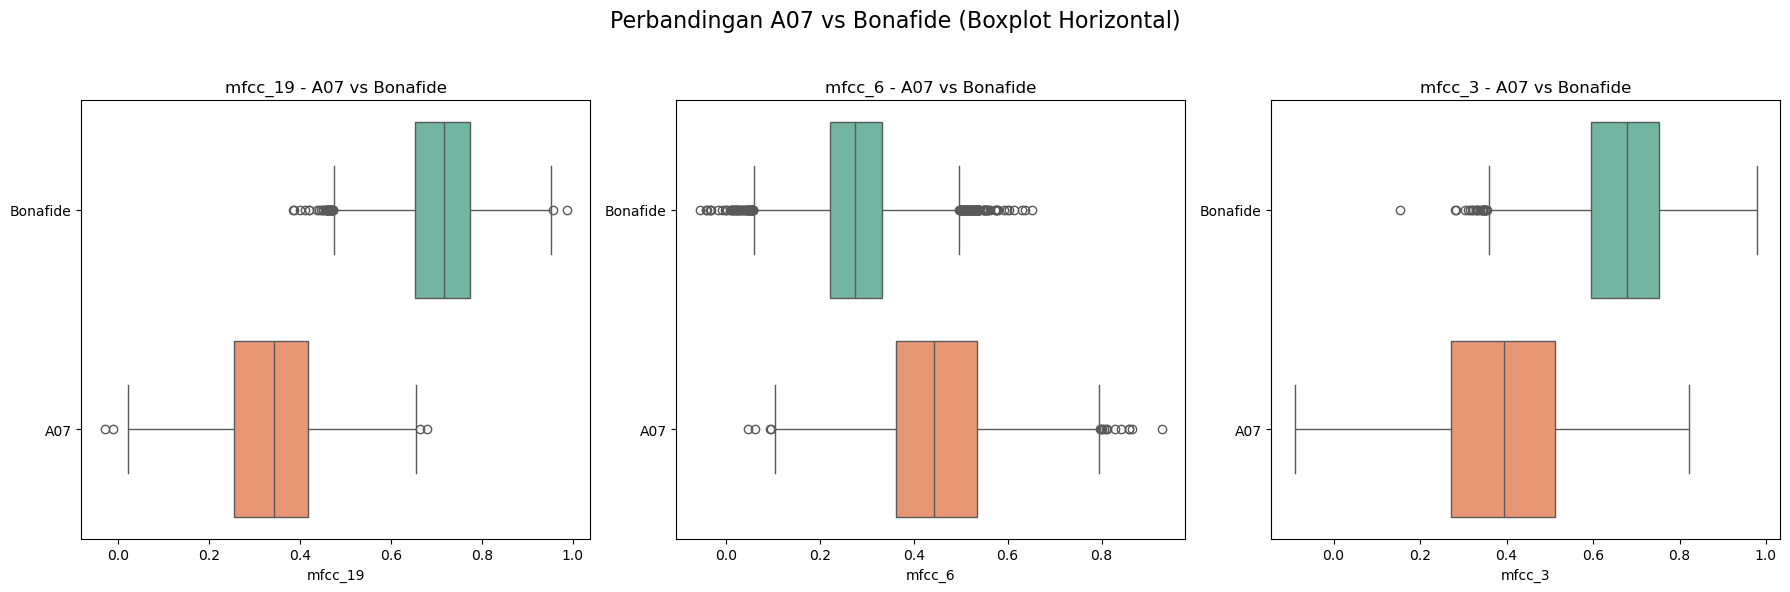

C:\Users\USER\AppData\Local\Temp\ipykernel_24940\3129242968.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\USER\AppData\Local\Temp\ipykernel_24940\3129242968.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\USER\AppData\Local\Temp\ipykernel_24940\3129242968.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


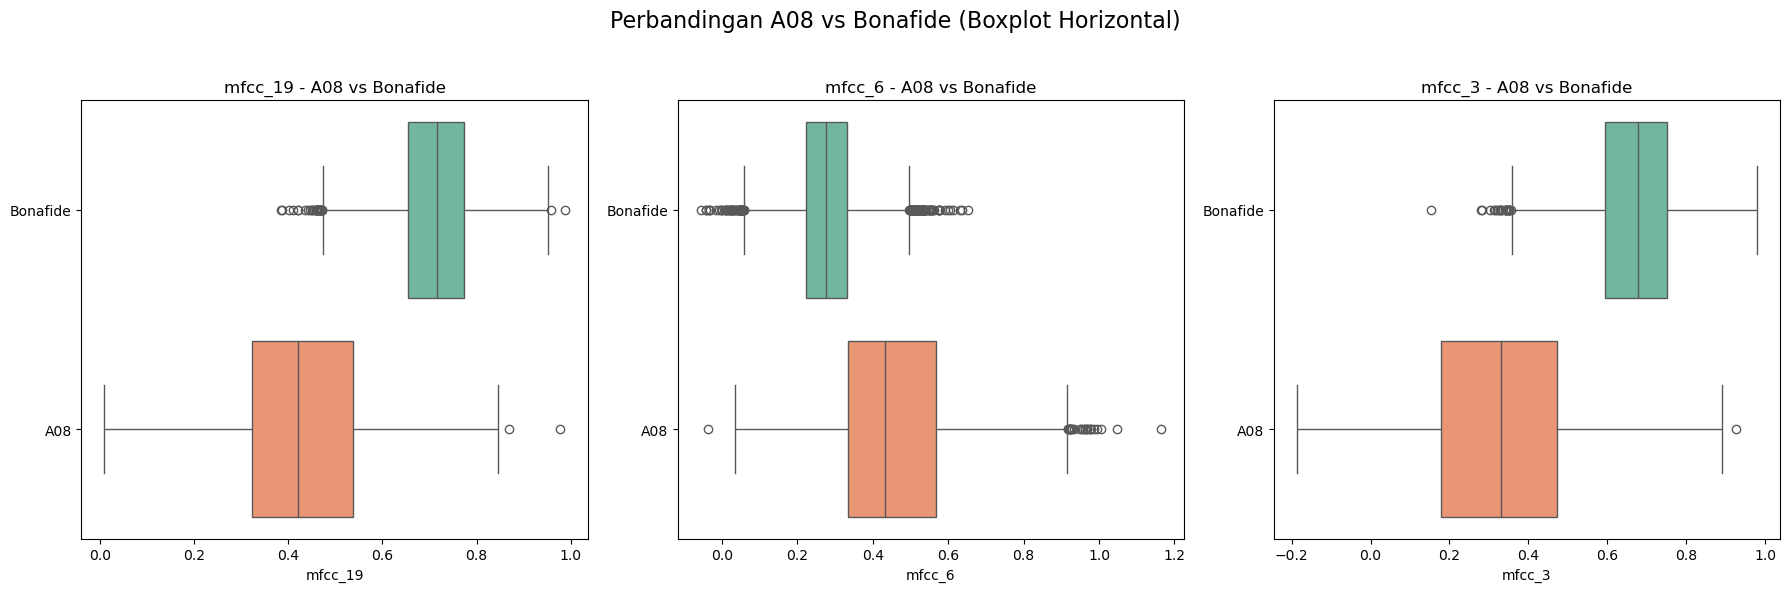

In [18]:
# Ganti tanda "-" menjadi "Bonafide" dengan cara yang benar
data_fitur["attack_id"] = data_fitur["attack_id"].replace({"-": "Bonafide"})

# Filter data untuk A07 vs Bonafide
data_a07_vs_bonafide = data_fitur[data_fitur["attack_id"].isin(["A07", "Bonafide"])]

# Filter data untuk A08 vs Bonafide
data_a08_vs_bonafide = data_fitur[data_fitur["attack_id"].isin(["A08", "Bonafide"])]

# Fungsi untuk membuat boxplot horizontal
def plot_box_comparison(data, attack_id, axes):
    features = ["mfcc_19", "mfcc_6", "mfcc_3"]
    for i, feature in enumerate(features):
        sns.boxplot(
            x=feature,
            y="attack_id",
            data=data,
            orient="h",
            ax=axes[i],
            palette="Set2"
        )
        axes[i].set_title(f"{feature} - {attack_id} vs Bonafide")
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel("")

# Plot untuk A07 vs Bonafide
fig_a07, axes_a07 = plt.subplots(1, 3, figsize=(18, 6))
plot_box_comparison(data_a07_vs_bonafide, "A07", axes_a07)
plt.suptitle("Perbandingan A07 vs Bonafide (Boxplot Horizontal)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Plot untuk A08 vs Bonafide
fig_a08, axes_a08 = plt.subplots(1, 3, figsize=(18, 6))
plot_box_comparison(data_a08_vs_bonafide, "A08", axes_a08)
plt.suptitle("Perbandingan A08 vs Bonafide (Boxplot Horizontal)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


C:\Users\USER\AppData\Local\Temp\ipykernel_20296\1406683714.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\USER\AppData\Local\Temp\ipykernel_20296\1406683714.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\USER\AppData\Local\Temp\ipykernel_20296\1406683714.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


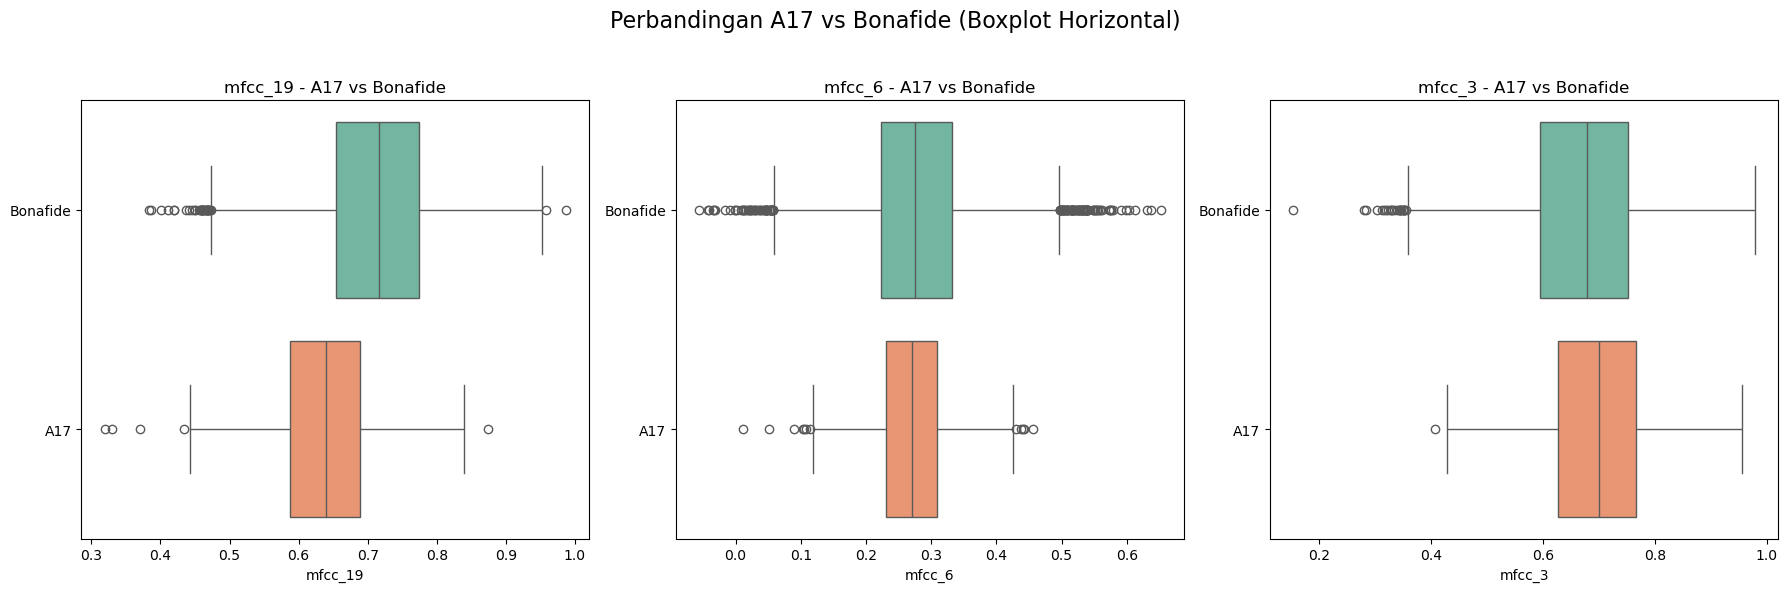

C:\Users\USER\AppData\Local\Temp\ipykernel_20296\1406683714.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\USER\AppData\Local\Temp\ipykernel_20296\1406683714.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(
C:\Users\USER\AppData\Local\Temp\ipykernel_20296\1406683714.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


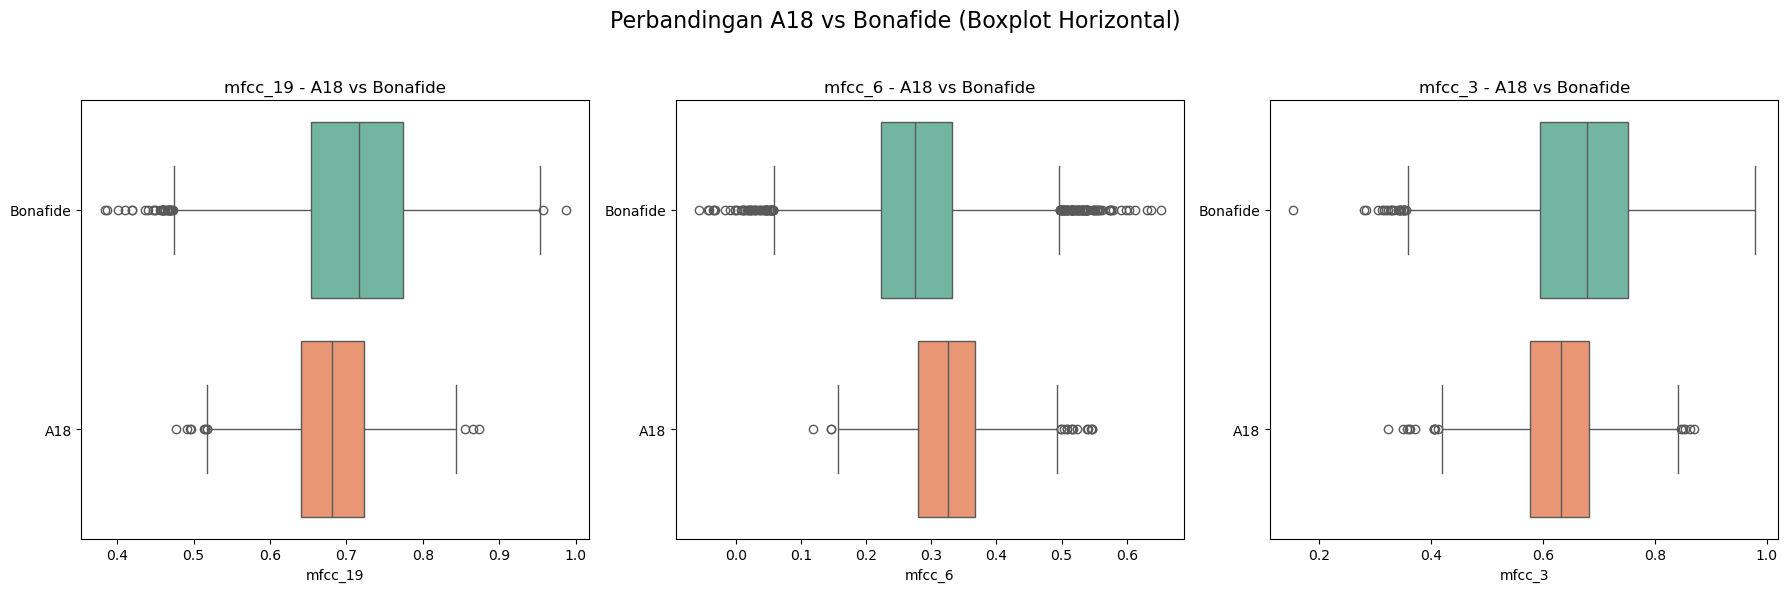

In [34]:
# Ganti tanda "-" menjadi "Bonafide" dengan cara yang benar
data_fitur["attack_id"] = data_fitur["attack_id"].replace({"-": "Bonafide"})

# Filter data untuk A17 vs Bonafide
data_A17_vs_bonafide = data_fitur[data_fitur["attack_id"].isin(["A17", "Bonafide"])]

# Filter data untuk A18 vs Bonafide
data_A18_vs_bonafide = data_fitur[data_fitur["attack_id"].isin(["A18", "Bonafide"])]

# Fungsi untuk membuat boxplot horizontal
def plot_box_comparison(data, attack_id, axes):
    features = ["mfcc_19", "mfcc_6", "mfcc_3"]
    for i, feature in enumerate(features):
        sns.boxplot(
            x=feature,
            y="attack_id",
            data=data,
            orient="h",
            ax=axes[i],
            palette="Set2"
        )
        axes[i].set_title(f"{feature} - {attack_id} vs Bonafide")
        axes[i].set_xlabel(feature)
        axes[i].set_ylabel("")

# Plot untuk A17 vs Bonafide
fig_A17, axes_A17 = plt.subplots(1, 3, figsize=(18, 6))
plot_box_comparison(data_A17_vs_bonafide, "A17", axes_A17)
plt.suptitle("Perbandingan A17 vs Bonafide (Boxplot Horizontal)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Plot untuk A18 vs Bonafide
fig_A18, axes_A18 = plt.subplots(1, 3, figsize=(18, 6))
plot_box_comparison(data_A18_vs_bonafide, "A18", axes_A18)
plt.suptitle("Perbandingan A18 vs Bonafide (Boxplot Horizontal)", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## Eksplorasi Gambar

### Contoh Spoofed

In [ ]:
def plot_mel_spectrogram(audio_path, sr=None, n_mels=128, fmax=None, hop_length=512):
    """
    Menampilkan visualisasi Mel-spectrogram dari file audio dengan judul nama file.

    Parameters:
    - audio_path : str
        Path ke file audio (misal: 'audio.wav')
    - sr : int or None
        Sample rate target. Jika None, gunakan sample rate asli.
    - n_mels : int
        Jumlah Mel bands.
    - fmax : int or None
        Frekuensi maksimum dalam Hz.
    - hop_length : int
        Ukuran langkah per frame (default = 512)
    """
    y, sr = librosa.load(audio_path, sr=sr)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels,
                                               fmax=fmax, hop_length=hop_length)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    file_name = os.path.basename(audio_path)  # ambil nama file saja

    plt.figure(figsize=(5, 4))
    librosa.display.specshow(mel_spec_db, sr=sr, hop_length=hop_length,
                              x_axis='time', y_axis='mel', fmax=fmax, cmap='coolwarm')
    plt.title(f'{file_name}')
    plt.colorbar(format='%+2.0f dB')
    plt.tight_layout()
    plt.show()



In [8]:
df = pd.read_csv("../data/processed/data_asv_spoof.csv")

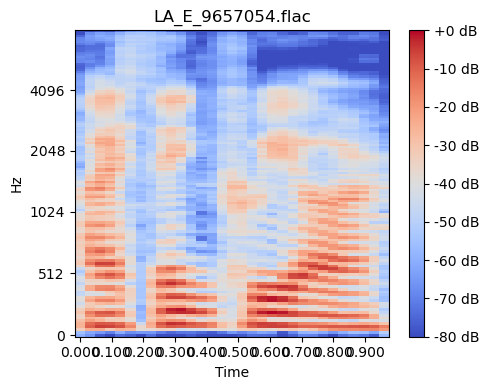

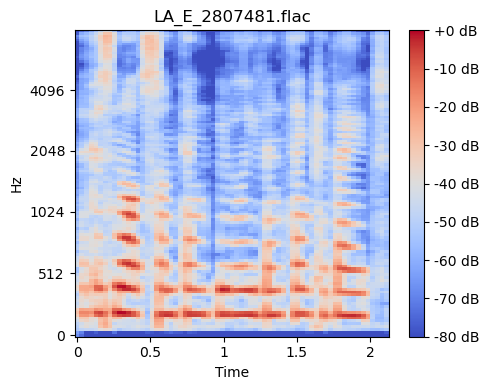

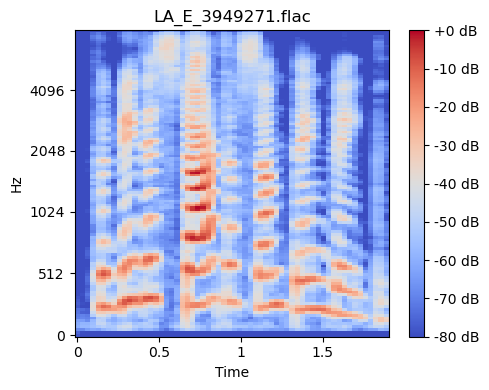

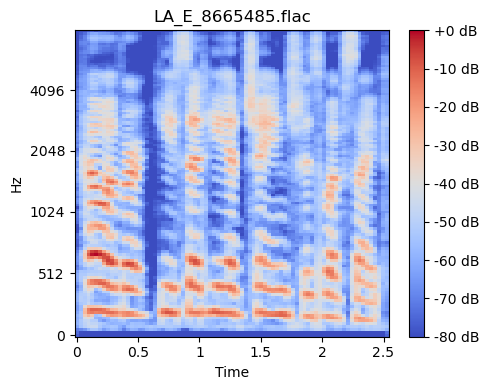

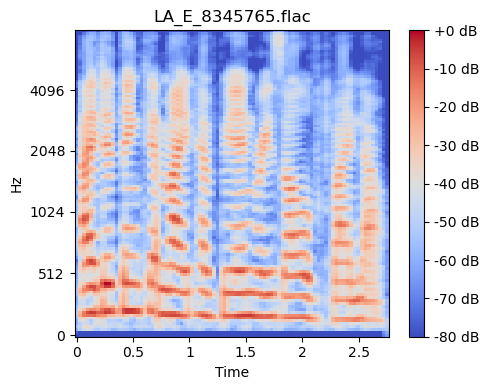

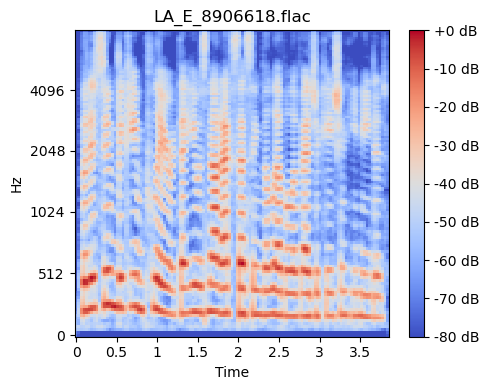

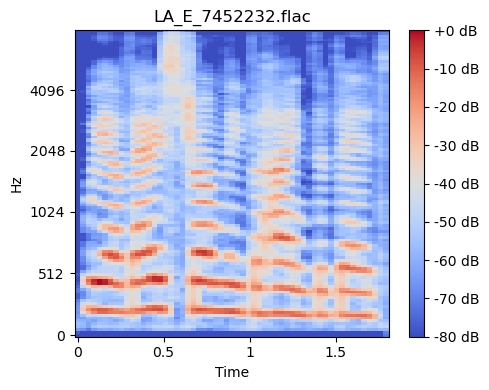

In [9]:
df_1 = df[df["attack_id"]=="A07"].sample(1000)
path_1 = df_1.iloc[:7,4]
for path in path_1:
    plot_mel_spectrogram(path)

### Contoh Bonafide

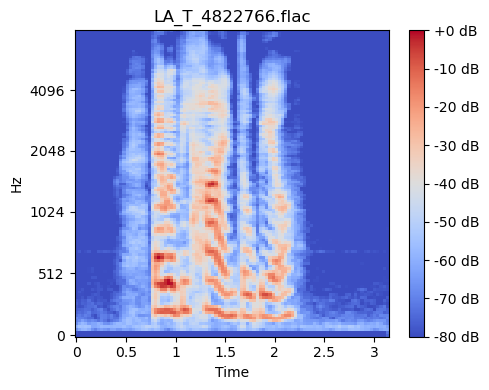

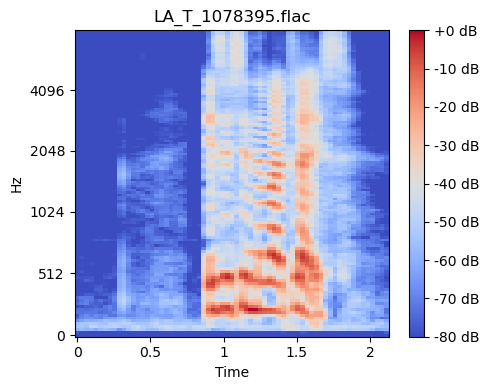

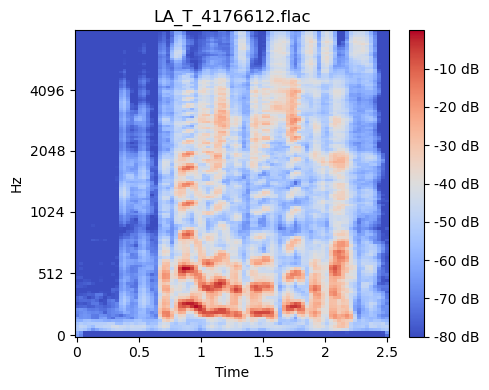

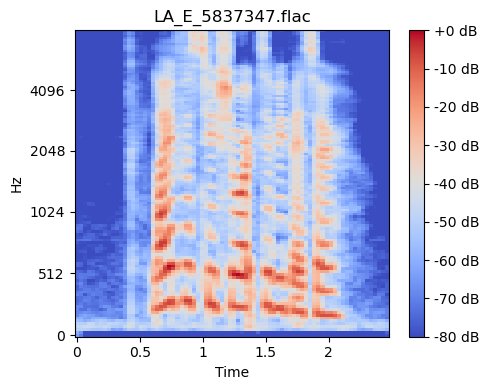

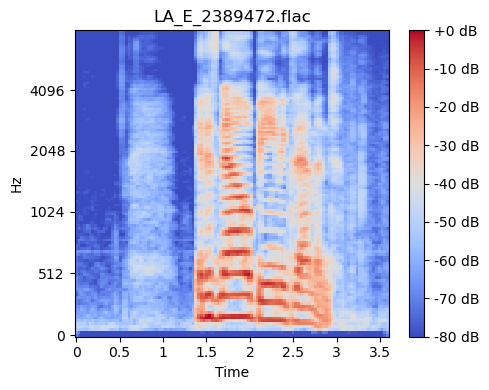

In [19]:
df_0 = df[df["target"]==0].sample(1000)
path_0 = df_0.iloc[:5,4]
for path in path_0:
    plot_mel_spectrogram(path)